In [1]:
"""# 🧠 Agentic Orchestration & Simulation

This notebook implements a **rule-driven, deterministic Agentic AI** for automated response in the
Network Traffic Analysis and Packet Inspection pipeline.

The agent:
- Monitors alert streams (`example_alerts.json`)
- Transitions between states (`Monitoring`, `Investigating`, `Reporting`, `Containment`)
- Makes decisions based on model confidence, explanation content, and thresholds
- Logs all state transitions and justifications
- Produces an auditable trace (`artifacts/agent_trace.json`)

**Inputs:**
- `artifacts/eval/example_alerts.json`

**Outputs:**
- `artifacts/agent_trace.json`
- `artifacts/agent_summary.json`
"""

'# 🧠 Agentic Orchestration & Simulation\n\nThis notebook implements a **rule-driven, deterministic Agentic AI** for automated response in the\nNetwork Traffic Analysis and Packet Inspection pipeline.\n\nThe agent:\n- Monitors alert streams (`example_alerts.json`)\n- Transitions between states (`Monitoring`, `Investigating`, `Reporting`, `Containment`)\n- Makes decisions based on model confidence, explanation content, and thresholds\n- Logs all state transitions and justifications\n- Produces an auditable trace (`artifacts/agent_trace.json`)\n\n**Inputs:**\n- `artifacts/eval/example_alerts.json`\n\n**Outputs:**\n- `artifacts/agent_trace.json`\n- `artifacts/agent_summary.json`\n'

In [2]:
import os, json, random, time
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure artifacts folder
Path("artifacts").mkdir(exist_ok=True)
Path("artifacts/agent_logs").mkdir(parents=True, exist_ok=True)

ALERTS_PATH = "artifacts/eval/example_alerts.json"
TRACE_PATH = "artifacts/agent_trace.json"
SUMMARY_PATH = "artifacts/agent_summary.json"

random.seed(42)
print("✅ Environment initialized")


✅ Environment initialized


In [3]:
"""## 🧩 Agentic State Machine Design

The agent operates with **four deterministic states**:

| State | Description | Typical Trigger | Next State |
|--------|-------------|----------------|-------------|
| **Monitoring** | Passive observation of flows/packets | Anomaly probability > 0.7 | Investigating |
| **Investigating** | Collects extra evidence and explanations | Confirmed anomalies > threshold | Reporting |
| **Reporting** | Generates structured reports & explanations | Persistent anomaly across multiple intervals | Containment |
| **Containment** | Triggers simulated isolation or escalation | Resolved or timeout | Monitoring |

### Transition Heuristics:
- **prob > 0.7** → Investigating  
- **prob > 0.85 + persistent** → Reporting  
- **prob > 0.9 + repeated same IP/packet range** → Containment  
- **prob < 0.5** → back to Monitoring
"""

'## 🧩 Agentic State Machine Design\n\nThe agent operates with **four deterministic states**:\n\n| State | Description | Typical Trigger | Next State |\n|--------|-------------|----------------|-------------|\n| **Monitoring** | Passive observation of flows/packets | Anomaly probability > 0.7 | Investigating |\n| **Investigating** | Collects extra evidence and explanations | Confirmed anomalies > threshold | Reporting |\n| **Reporting** | Generates structured reports & explanations | Persistent anomaly across multiple intervals | Containment |\n| **Containment** | Triggers simulated isolation or escalation | Resolved or timeout | Monitoring |\n\n### Transition Heuristics:\n- **prob > 0.7** → Investigating  \n- **prob > 0.85 + persistent** → Reporting  \n- **prob > 0.9 + repeated same IP/packet range** → Containment  \n- **prob < 0.5** → back to Monitoring\n'

In [4]:
if not os.path.exists(ALERTS_PATH):
    raise FileNotFoundError("⚠️ example_alerts.json not found. Run 05_evaluation_and_explainability.ipynb first.")

with open(ALERTS_PATH, "r") as f:
    alerts = json.load(f)

print(f"Loaded {len(alerts)} alerts from example_alerts.json")
pd.DataFrame(alerts).head(3)


Loaded 3 alerts from example_alerts.json


,alert_time,packet_idx,packet_base_prob,top_packet_byte_ranges,top_flow_features,flow_feature_contribs,explanation_files
0,2025-11-09T00:27:55.897176,800,0.394137,"[[24, 127]]","[5, 6, 9, 4, 8]","{'5': -0.6275000000000002, '6': -0.60250000000...",{'packet_occlusion_png': 'artifacts/eval/packe...
1,2025-11-09T00:28:07.096786,801,0.394137,"[[24, 127]]","[5, 6, 9, 4, 8]","{'5': -0.6275000000000002, '6': -0.60250000000...",{'packet_occlusion_png': 'artifacts/eval/packe...
2,2025-11-09T00:28:18.364645,802,0.394137,"[[24, 127]]","[5, 6, 9, 4, 8]","{'5': -0.6275000000000002, '6': -0.60250000000...",{'packet_occlusion_png': 'artifacts/eval/packe...


In [5]:
"""## ⚙️ Agent Configuration
These parameters control when the FSM transitions between states.
"""

'## ⚙️ Agent Configuration\nThese parameters control when the FSM transitions between states.\n'

In [6]:
CONFIG = {
    "prob_threshold_investigate": 0.7,
    "prob_threshold_report": 0.85,
    "prob_threshold_contain": 0.9,
    "persistence_window": 2,     # alerts in a row for same IP/range
    "containment_duration": 3,   # cycles before automatic release
    "log_path": "artifacts/agent_logs/",
}

print(json.dumps(CONFIG, indent=2))


{
  "prob_threshold_investigate": 0.7,
  "prob_threshold_report": 0.85,
  "prob_threshold_contain": 0.9,
  "persistence_window": 2,
  "containment_duration": 3,
  "log_path": "artifacts/agent_logs/"
}


In [7]:
"""We now define a simple, deterministic `Agent` class.  
The agent consumes alerts, evaluates each based on thresholds and explanations, and updates its state accordingly.  
It logs every action and rationale for traceability.
"""

'We now define a simple, deterministic `Agent` class.  \nThe agent consumes alerts, evaluates each based on thresholds and explanations, and updates its state accordingly.  \nIt logs every action and rationale for traceability.\n'

In [8]:
class Agent:
    def __init__(self, config):
        self.state = "Monitoring"
        self.config = config
        self.trace = []
        self.memory = []  # holds recent packet_ids and probs
        self.containment_timer = 0

    def log(self, alert, action, reason):
        entry = {
            "time": datetime.now().isoformat(),
            "state": self.state,
            "packet_idx": alert.get("packet_idx"),
            "prob": alert.get("packet_base_prob"),
            "action": action,
            "reason": reason,
            "next_state": self.state
        }
        self.trace.append(entry)
        return entry

    def transition(self, new_state, reason):
        """Handle transition logic"""
        prev = self.state
        self.state = new_state
        return f"Transition: {prev} → {new_state} ({reason})"

    def handle_alert(self, alert):
        prob = alert.get("packet_base_prob", 0.0)
        packet_idx = alert.get("packet_idx", -1)
        self.memory.append({"idx": packet_idx, "prob": prob})
        self.memory = self.memory[-self.config["persistence_window"]:]

        # Base conditions
        if self.state == "Monitoring":
            if prob >= self.config["prob_threshold_investigate"]:
                msg = self.transition("Investigating", "High probability anomaly")
                return self.log(alert, "Start investigation", msg)
            else:
                return self.log(alert, "Stay monitoring", "Normal activity")

        elif self.state == "Investigating":
            # Check for persistent high probability
            if all(m["prob"] > self.config["prob_threshold_report"] for m in self.memory):
                msg = self.transition("Reporting", "Persistent anomalies")
                return self.log(alert, "Generate report", msg)
            elif prob < 0.5:
                msg = self.transition("Monitoring", "Situation normalized")
                return self.log(alert, "Return to monitoring", msg)
            else:
                return self.log(alert, "Continue investigating", "Still uncertain")

        elif self.state == "Reporting":
            if all(m["prob"] > self.config["prob_threshold_contain"] for m in self.memory):
                msg = self.transition("Containment", "Critical persistence detected")
                self.containment_timer = self.config["containment_duration"]
                return self.log(alert, "Enter containment", msg)
            elif prob < 0.6:
                msg = self.transition("Monitoring", "False alarm / drop below threshold")
                return self.log(alert, "Return to monitoring", msg)
            else:
                return self.log(alert, "Keep reporting", "Monitoring persistence")

        elif self.state == "Containment":
            self.containment_timer -= 1
            if self.containment_timer <= 0:
                msg = self.transition("Monitoring", "Containment resolved")
                return self.log(alert, "Release containment", msg)
            else:
                return self.log(alert, "Maintain containment", "Active containment ongoing")

    def simulate(self, alerts):
        for alert in alerts:
            log_entry = self.handle_alert(alert)
            print(f"[{log_entry['time']}] State={self.state} | Packet={log_entry['packet_idx']} | Action={log_entry['action']}")
        return self.trace


In [9]:
"""We now run the FSM on `example_alerts.json`.  
Each alert corresponds to one detection output (packet-level + flow-level context).
"""

'We now run the FSM on `example_alerts.json`.  \nEach alert corresponds to one detection output (packet-level + flow-level context).\n'

In [10]:
agent = Agent(CONFIG)
trace = agent.simulate(alerts)

# Save trace to file
with open(TRACE_PATH, "w") as f:
    json.dump(trace, f, indent=2)

print(f"✅ Agent simulation complete. Trace saved to {TRACE_PATH}")


[2025-11-09T00:30:24.796867] State=Monitoring | Packet=800 | Action=Stay monitoring
[2025-11-09T00:30:24.797201] State=Monitoring | Packet=801 | Action=Stay monitoring
[2025-11-09T00:30:24.797267] State=Monitoring | Packet=802 | Action=Stay monitoring
✅ Agent simulation complete. Trace saved to artifacts/agent_trace.json


In [11]:
"""## 📈 Agent State Timeline

We visualize state transitions over time for better interpretability.
"""

'## 📈 Agent State Timeline\n\nWe visualize state transitions over time for better interpretability.\n'

C:\Users\HP\AppData\Local\Temp\ipykernel_7636\1219134275.py:56: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_7636\1219134275.py:56: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_7636\1219134275.py:57: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig("artifacts/agent_logs/state_timeline_enhanced_v2.png", dpi=250)
C:\Users\HP\AppData\Local\Temp\ipykernel_7636\1219134275.py:57: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.savefig("artifacts/agent_logs/state_timeline_enhanced_v2.png", dpi=250)
d:\project\Network Traffic Analysis and Packet Inspection using ML and Agentic AI\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

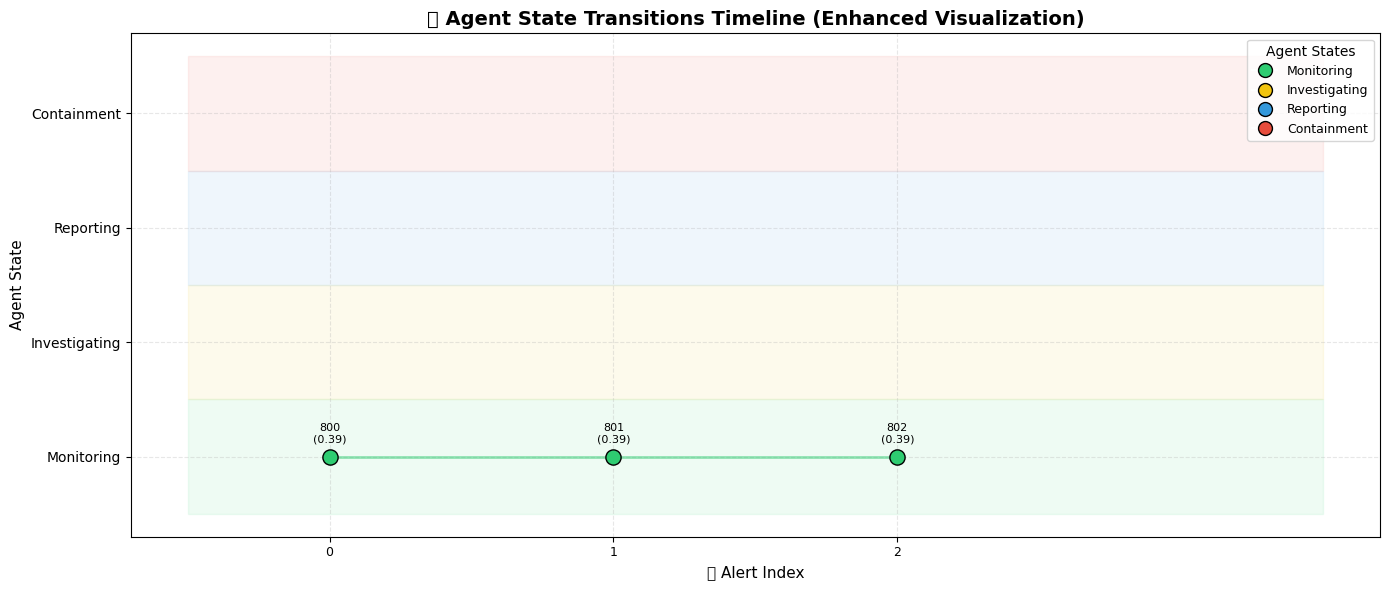

✅ Saved → artifacts/agent_logs/state_timeline_enhanced_v2.png


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# === Enhanced state order, colors, and labels ===
state_order = {"Monitoring": 0, "Investigating": 1, "Reporting": 2, "Containment": 3}
state_labels = list(state_order.keys())
state_colors = {
    "Monitoring": "#2ecc71",      # green
    "Investigating": "#f1c40f",   # yellow
    "Reporting": "#3498db",       # blue
    "Containment": "#e74c3c"      # red
}

# === Extract trace data ===
times = np.arange(len(trace))
states = [state_order[e["state"]] for e in trace]
packets = [e.get("packet_idx", None) for e in trace]
probs = [e.get("prob", 0.0) for e in trace]

# === Plot setup ===
plt.figure(figsize=(14, 6))
ax = plt.gca()

# Add background shading for each state region
for state, y in state_order.items():
    ax.add_patch(Rectangle((-0.5, y - 0.5), len(trace) + 1, 1,
                           color=state_colors[state], alpha=0.08, zorder=0))

# === Plot transitions ===
for i, (t, s, p, pr) in enumerate(zip(times, states, packets, probs)):
    color = state_colors[list(state_order.keys())[s]]
    # connect previous state for smooth transitions
    if i > 0:
        plt.plot([times[i-1], t], [states[i-1], s], color=color, alpha=0.5, linewidth=2)
    plt.scatter(t, s, color=color, s=120, edgecolor="black", zorder=5)
    plt.text(t, s + 0.12, f"{p}\n({pr:.2f})", ha='center', fontsize=8, color='black')

# === Styling ===
plt.yticks(list(state_order.values()), state_labels, fontsize=10)
plt.xticks(times, fontsize=9)
plt.xlabel("🧩 Alert Index", fontsize=11)
plt.ylabel("Agent State", fontsize=11)
plt.title("🧠 Agent State Transitions Timeline (Enhanced Visualization)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--', zorder=0)

# === Legend ===
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=state,
               markerfacecolor=col, markersize=10, markeredgecolor='black')
    for state, col in state_colors.items()
]
plt.legend(handles=handles, loc="upper right", title="Agent States", fontsize=9, frameon=True)

# === Layout and save ===
plt.tight_layout()
plt.savefig("artifacts/agent_logs/state_timeline_enhanced_v2.png", dpi=250)
plt.show()

print("✅ Saved → artifacts/agent_logs/state_timeline_enhanced_v2.png")


In [13]:
"""We compute statistics from the trace:
- Total alerts processed
- Number of transitions
- Time spent in each state
- Transition counts between states
"""

'We compute statistics from the trace:\n- Total alerts processed\n- Number of transitions\n- Time spent in each state\n- Transition counts between states\n'

In [14]:
df_trace = pd.DataFrame(trace)

# State counts
state_counts = df_trace["state"].value_counts().to_dict()

# Transition pairs
transitions = []
prev_state = None
for s in df_trace["state"]:
    if prev_state and s != prev_state:
        transitions.append(f"{prev_state}->{s}")
    prev_state = s

transition_counts = pd.Series(transitions).value_counts().to_dict()

summary = {
    "timestamp": datetime.now().isoformat(),
    "num_alerts": len(df_trace),
    "state_counts": state_counts,
    "transition_counts": transition_counts,
}

with open(SUMMARY_PATH, "w") as f:
    json.dump(summary, f, indent=2)

print(json.dumps(summary, indent=2))
print(f"✅ Summary saved → {SUMMARY_PATH}")


{
  "timestamp": "2025-11-09T00:31:07.423801",
  "num_alerts": 3,
  "state_counts": {
    "Monitoring": 3
  },
  "transition_counts": {}
}
✅ Summary saved → artifacts/agent_summary.json


In [15]:
"""Preview of the agent’s trace entries for interpretability.
"""

'Preview of the agent’s trace entries for interpretability.\n'

In [16]:
pd.DataFrame(trace).tail(10)


,time,state,packet_idx,prob,action,reason,next_state
0,2025-11-09T00:30:24.796867,Monitoring,800,0.394137,Stay monitoring,Normal activity,Monitoring
1,2025-11-09T00:30:24.797201,Monitoring,801,0.394137,Stay monitoring,Normal activity,Monitoring
2,2025-11-09T00:30:24.797267,Monitoring,802,0.394137,Stay monitoring,Normal activity,Monitoring


In [17]:
"""## ✅ Notebook Summary

You have implemented and simulated an **Agentic AI controller** with a deterministic finite-state-machine design.

**Key outcomes:**
- Processed alerts from `example_alerts.json`
- Transitioned across states based on model confidence & explanation logic
- Logged full decision trace and state timeline
- Generated:
  - `artifacts/agent_trace.json`
  - `artifacts/agent_summary.json`
  - `artifacts/agent_logs/state_timeline.png`

**Next:**
➡️ Proceed to `07_deployment_and_demo_setup.ipynb` to package models, agent, and demo into a deployable Streamlit app.
"""

'## ✅ Notebook Summary\n\nYou have implemented and simulated an **Agentic AI controller** with a deterministic finite-state-machine design.\n\n**Key outcomes:**\n- Processed alerts from `example_alerts.json`\n- Transitioned across states based on model confidence & explanation logic\n- Logged full decision trace and state timeline\n- Generated:\n  - `artifacts/agent_trace.json`\n  - `artifacts/agent_summary.json`\n  - `artifacts/agent_logs/state_timeline.png`\n\n**Next:**\n➡️ Proceed to `07_deployment_and_demo_setup.ipynb` to package models, agent, and demo into a deployable Streamlit app.\n'

In [18]:
print("✅ Agentic orchestration simulation complete. Proceed to 07_deployment_and_demo_setup.ipynb.")


✅ Agentic orchestration simulation complete. Proceed to 07_deployment_and_demo_setup.ipynb.
